In [2]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np
import copy
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../induction_motor_anomaly_detection/')
import modules,scaler

In [91]:

class OnlineIsolationForest:
    def __init__(self, n_estimators=100, max_samples=256, contamination='auto', random_state=42):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.contamination = contamination
        self.random_state = random_state
        self.iforest = None
        self.X = np.array([])

    def fit(self, X):
        if self.iforest is None:
            self.iforest = IsolationForest(n_estimators=self.n_estimators,
                                           max_samples=self.max_samples,
                                           contamination=self.contamination,
                                           random_state=self.random_state)
            
            if(self.X.ndim == 1):
                self.X = [X]
                self.iforest.fit(self.X)
                
            else:
                self.X = X
                self.iforest.fit(self.X)
                
        else:
            self.iforest.set_params(n_estimators=self.n_estimators,
                                    max_samples=self.max_samples,
                                    contamination=self.contamination,
                                    random_state=self.random_state)
            self.X = np.concatenate((self.X,[X]), axis=0)
            self.iforest.fit(self.X)


    def predict(self, X):
        if self.iforest is not None:
            return self.iforest.predict(X)
        else:
            raise ValueError("Isolation Forest not yet fit")


In [5]:
normal_data = pd.read_csv('../data/combined_data.csv')
anomalous_data = pd.read_csv('../anomalous_data/anomalous_data.csv')


In [22]:
train_data_features = modules.ElectricalFeatureExtractor(current_data=normal_data)
test_data_features = modules.ElectricalFeatureExtractor(current_data=anomalous_data)
train_scaler = scaler.Scaler()
train_scaler.fit_unlabelled_data(train_data_features.feature_dataframe[0])
train_scaled = train_scaler.transform(train_data_features.feature_dataframe[0])
test_scaled = train_scaler.transform(test_data_features.feature_dataframe[0])

In [98]:
anomaly_detector = OnlineIsolationForest(n_estimators=317, max_samples=64, contamination=0.01, random_state=42)


takes a while to fit

In [99]:
for data in train_scaled:
    anomaly_detector.fit(data)


In [102]:
anomaly_scores = anomaly_detector.predict(train_scaled)

In [106]:
np.where(anomaly_scores == -1)[0]

array([230, 231, 232, 242], dtype=int64)

In [109]:
anomaly_detector.predict(test_scaled)


array([-1])

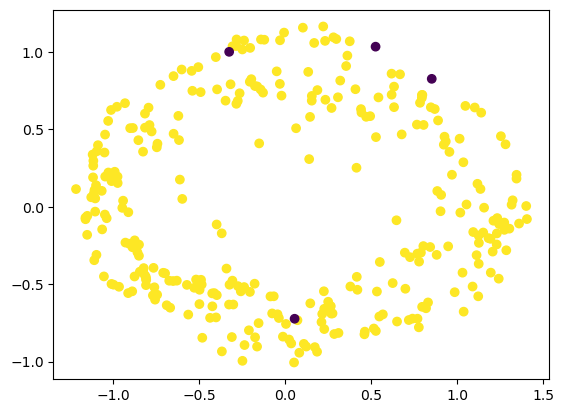

In [112]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# assuming you have already scaled and preprocessed the data and stored it in variable X

pca = PCA(n_components=2)
X_2d = pca.fit_transform(train_scaled)

# assuming you have already fit the anomaly detection model and stored it in variable anomaly_detector
anomaly_predictions = anomaly_detector.predict(train_scaled)

# scatter plot of the data points colored by anomaly label
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=anomaly_predictions)
plt.show()